<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/output-spikes/OutputSpikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
# !pip install brian2

In [3]:
!pip install torch

In [4]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 48.4 MB/s eta 0:00:00


In [5]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.5 MB/s eta 0:00:00


In [6]:
!pip install torchsummary

## set seeds for PyTorch and Numpy to ensure reproducibility:

In [7]:
import torch
import random
import numpy as np

# Set seeds for Python, Numpy, and Torch for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Additional steps if you're using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [8]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn as nn
from scipy.stats import entropy
from scipy.special import kl_div
from torch.autograd import Variable
# import spikeflow as snn

In [9]:
# torch.autograd.set_detect_anomaly(True)

In [10]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 346351696.07it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 12618301.44it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 138606128.68it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1349569.90it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [39]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')

if not os.path.isdir('Output_Spikes/'):
    os.makedirs('Output_Spikes/')

if not os.path.isdir('Enc_syn_Spikes/'):
    os.makedirs('Enc_syn_Spikes/')


if not os.path.isdir('Intermediate_Lyrs/'):
    os.makedirs('Intermediate_Lyrs/')



In [40]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using Tesla T4 (cuda)


### To manipulate and test (Working for Encoder and Decoder outputs):

In [41]:
# class SAE(nn.Module):
#     def __init__(self):
#         super().__init__()


#         # Encoder
#         self.encoder = nn.Sequential(
#                             nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
#                             # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
#                                 # bias=True, padding_mode='zeros',  device=None, dtype=None)
#                             nn.BatchNorm2d(32),
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
#                             nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
#                             nn.BatchNorm2d(64),
#                             # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
#                             # snn.Alpha(alpha=alpha1, beta=beta1, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
#                             nn.BatchNorm2d(128),
#                             # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
#                             # snn.Alpha(alpha=alpha11, beta=beta11, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
#                             nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
#                             # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
#                             )


#         self.latent_dim = latent_dim #dimensions of the encoded z-space data

#         #ve from the flattened encoded representation (latent_dim) back to a tensor representation to
#             # use in transposed convolution.
#           # To do so, we need to run an additional fully-connected linear layer transforming the data back into a tensor of 128 x 4 x 4:

#         self.linearNet= nn.Sequential(
#                                       nn.Linear(latent_dim,128*4*4),
#                                       snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))
#                                       #snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))




#       #  The decoder, with three transposed convolutional (nn.ConvTranspose2d) layers and one linear output layer.
#       # Although we converted the latent data back into tensor form for convolution, we still need to Unflatten it to a tensor of 128 x 4 x 4,
#         # as the input to the network is 1 dimensional.  This is done using nn.Unflatten in the first line of the Decoder:
#         # Decoder:
#         self.decoder = nn.Sequential(
#                             nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
#                             nn.BatchNorm2d(64),
#                             # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             # snn.Alpha(alpha=alpha2, beta=beta2, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
#                             nn.BatchNorm2d(32),
#                             # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             # snn.Alpha(alpha=alpha22, beta=beta22, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
#                             # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=thresh) #---------------------------------------------- ADDED
#                             # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
#                             )
#         # final Leaky layer, our spiking threshold (thresh) is set extremely high. This is a neat trick in snnTorch, which allows the neuron
#         # membrane in the final layer to continuously be updated, without ever reaching a spiking threshold.

#         # using the membrane potential output from the final layer for the image reconstruction.
#             # snnTorch allows us to use either the spikes or membrane potential of each neuron in training.


#     def forward(self, x):
#         utils.reset(self.encoder) #need to reset the hidden states of LIF
#         utils.reset(self.decoder)
#         utils.reset(self.linearNet)

#     #-----------------------------encode
#         spk_mem=[];
#         spk_rec=[];
#         spk_rec_syn=[];
#         encoder_mem=[];
#         spk_rec_dec=[];
#         spk_mem_dec=[];
#         for step in range(num_steps): #for t in time
#             spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
#             # print("Size of = self.encode(x):", self.encode(x).size())
#             # print("len of = self.encode(x):", len(self.encode(x)))
#             spk_rec.append(spk_x)
#             spk_mem.append(mem_x)

#         spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension
#         spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension
# # torch.stack joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension.
#         # print("Size of spk_rec:", spk_rec.size())   # Size of spk_rec: torch.Size([250, 32, 5])
#         # print("Size of spk_mem:", spk_mem.size()) # Size of spk_mem: torch.Size([250, 32, 5])
#         # out_en = spk_rec[:,:,-1]     #//////////////////////////////////////ADDED---------------- shows  batch size (250) different examples on (32) channel number
#         out_en = spk_rec[0, :,:] #//////////////////////////////////////ADDED------------ latent dim (32) and time (num_steps)(5)
#         # print("Size of out_en:", out_en.size()) #Size of out_en: torch.Size([250, 32])

#     #------------------------------decode
#         spk_mem2=[];
#         spk_rec2=[];
#         decoded_x=[];
#         spk_x_dec=[];
#         mem_x_dec=[];
#         for step in range(num_steps): #for t in time
#             # spk_x_dec, mem_x_dec = self.decode(spk_rec[...,step]) #//////////////////////////ADDED
#             x_recon, x_mem_recon = self.decode(spk_rec[...,step])

#             spk_rec2.append(x_recon)
#             spk_mem2.append(x_mem_recon)

#             # spk_rec_dec.append(spk_x_dec)   #//////////////////////////ADDED Size of spk_rec_dec: torch.Size([250, 1, 5, 32, 32])
#             # spk_mem_dec.append(mem_x_dec)   #//////////////////////////ADDED

#         # spk_rec_dec=torch.stack(spk_rec_dec,dim=2) #//////////////////////////ADDED
#         # spk_mem_dec=torch.stack(spk_mem_dec,dim=2) #//////////////////////////ADDED
#         spk_rec2=torch.stack(spk_rec2,dim=4)
#         spk_mem2=torch.stack(spk_mem2,dim=4)

#         # out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
#         # out = spk_rec2[:,:,:,:,-1]  #//////////////////////////ADDED #  Size of out: torch.Size([250, 1, 32, 32])
#         # out = spk_rec_dec[:,:,-1] #//////////////////////////ADDED  # Size of out: torch.Size([250, 1, 32, 32])
#         # out = spk_rec_dec[:,0,:,-1] #//////////////////////////ADDED  # Size of out: torch.Size([250, 5, 32])
#         # out = spk_rec_dec[:,0,0,:,-1] #//////////////////////////ADDED  # Size of out: torch.Size([250, 32])
#         # out = spk_rec_dec[:,-1] #//////////////////////////ADDED  Size of out: torch.Size([250, 5, 32, 32])
#         # out = spk_rec2[0,0,:,:] #//////////////////////////ADDED Now working with [250, 1, 32, 32]) because it is (torch.Size([32, 32, 5]))
#         out = spk_mem2[:,:,:,:,-1]  #//////////////////////////ADDED #  Size of out: torch.Size([250, 1, 32, 32])--------------- for one digit at the last time t

#         # print("Size of out:", out.size())

#         # Save the out_en tensor
#         self.out_en = out_en
#         self.out = out

#         return out, out_en


#     def encode(self,x):
#       spk_latent_x, mem_latent_x = self.encoder(x)
#       return spk_latent_x, mem_latent_x, syn1, memsyn1

#     def decode(self,x):
#         spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
#         spk_x2, mem_x2 = self.decoder(spk_x)
#         return spk_x2, mem_x2

### Working with "out" and "out_en":


In [42]:
# class SAE(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Encoder
#         self.encoder = nn.Sequential(
#                             nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
#                             nn.BatchNorm2d(32),
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
#                             nn.BatchNorm2d(64),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
#                             nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
#                             nn.BatchNorm2d(128),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
#                             nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
#                             nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
#                             )
#         self.latent_dim = latent_dim #dimensions of the encoded z-space data
#         self.linearNet= nn.Sequential(
#                                       nn.Linear(latent_dim,128*4*4),
#                                       snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))

#         # Decoder:
#         self.decoder = nn.Sequential(
#                             nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
#                             nn.BatchNorm2d(64),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
#                             nn.BatchNorm2d(32),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
#                             )
#     def forward(self, x):
#         utils.reset(self.encoder) #need to reset the hidden states of LIF
#         utils.reset(self.decoder)
#         utils.reset(self.linearNet)

#     #-----------------------------encode
#         spk_mem=[];
#         spk_rec=[];
#         spk_rec_syn=[];
#         encoder_mem=[];
#         spk_rec_dec=[];
#         spk_mem_dec=[];
#         for step in range(num_steps): #for t in time
#             spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
#             # print("spk_x in spk_x, mem_x = self.encode(x): ",spk_x.size())    #                       torch.Size([250, 32])
#             # print("mem_x in spk_x, mem_x = self.encode(x): ",mem_x.size())    #                       torch.Size([250, 32])
#             spk_rec.append(spk_x)
#             spk_mem.append(mem_x)
#             # print("len of spk_rec in spk_rec.append(spk_x): ",len(spk_rec))
#             # print("len of spk_mem in spk_rec.append(mem_x): ",len(spk_mem))

#         spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension # ----------------spk_rec in torch.stack(spk_rec,dim=2):  torch.Size([250, 32, 5])
#         # print("----------------spk_rec in torch.stack(spk_rec,dim=2): ",spk_rec.size())
#         spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension # ----------------spk_mem in torch.stack(spk_mem,dim=2):  torch.Size([250, 32, 5])
#         # print("----------------spk_mem in torch.stack(spk_mem,dim=2): ",spk_mem.size())
#         # out_en = spk_rec[0, :,:] #//////////////////////////////////////ADDED------------ latent dim (32) and time (num_steps)(5) # out_en in spk_rec[0, :,:]:----------- torch.Size([32, 5])
#         # print("out_en in spk_rec[0, :,:]:-----------" , out_en.size())
#         out_en = spk_rec[...,step]
#         # print("spk_rec[...,step]:-----------" , spk_rec[...,step].size()) # spk_rec[...,step]:----------- torch.Size([250, 32])       input of the latent and then decoder




#     #------------------------------decode
#         spk_mem2=[];
#         spk_rec2=[];
#         decoded_x=[];
#         spk_x_dec=[];
#         mem_x_dec=[];
#         for step in range(num_steps): #for t in time                                   from decoder: ([250, 1, 32, 32])
#             x_recon, x_mem_recon = self.decode(spk_rec[...,step])                             # x_recon in self.decode(spk_rec[...,step]): torch.Size([250, 1, 32, 32])
#             # print("x_recon in self.decode(spk_rec[...,step]):" , x_recon.size())            # x_mem_recon in self.decode(spk_rec[...,step]): torch.Size([250, 1, 32, 32])
#             # print("x_mem_recon in self.decode(spk_rec[...,step]):" , x_mem_recon.size())

#             spk_rec2.append(x_recon)
#             spk_mem2.append(x_mem_recon)
#             # print("len of spk_rec2.append(x_recon)",len(spk_rec2))
#             # print("len of spk_mem2.append(x_recon)",len(spk_mem2))

#         spk_rec2=torch.stack(spk_rec2,dim=4)
#         spk_mem2=torch.stack(spk_mem2,dim=4)
#         # print("spk_rec2 in torch.stack(spk_rec2,dim=4):", spk_rec2.size())          # spk_rec2 in torch.stack(spk_rec2,dim=4): torch.Size([250, 1, 32, 32, 5])
#         # print("spk_mem2 in torch.stack(spk_rec2,dim=4):", spk_mem2.size())          # spk_mem2 in torch.stack(spk_rec2,dim=4): torch.Size([250, 1, 32, 32, 5])

#         out = spk_mem2[:,:,:,:,-1]  #//////////////////////////ADDED #  Size of out: torch.Size([250, 1, 32, 32])--------------- for one digit at the last time t

#         # self.out_en = out_en
#         # self.out = out

#         return out, out_en


#     def encode(self,x):
#       spk_latent_x, mem_latent_x = self.encoder(x)
#       return spk_latent_x, mem_latent_x

#     def decode(self,x):
#         spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
#         spk_x2, mem_x2 = self.decoder(spk_x)
#         return spk_x2, mem_x2

In [43]:
class SAE(nn.Module):
    def __init__(self):
        super().__init__()


        # encoder_layers = [
        #     ('conv1', nn.Conv2d(1, 32, 3, padding=1, stride=2)),  # Conv Layer 1
        #     ('batchnorm1', nn.BatchNorm2d(32)),
        #     ('leaky1', snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)),
        #     ('conv2', nn.Conv2d(32, 64, 3, padding=1, stride=2)),  # Conv Layer 2
        #     ('batchnorm2', nn.BatchNorm2d(64)),
        #     ('synaptic1', snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)),  # SNN TORCH LIF NEURON
        #     ('conv3', nn.Conv2d(64, 128, 3, padding=1, stride=2)),  # Conv Layer 3
        #     ('batchnorm3', nn.BatchNorm2d(128)),
        #     ('synaptic2', snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)),  # SNN TORCH LIF NEURON
        #     ('flatten', nn.Flatten(start_dim=1, end_dim=3)),  # Flatten convolutional output
        #     ('linear', nn.Linear(128 * 4 * 4, latent_dim)),  # Fully connected linear layer
        #     ('leaky2', snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh))
        # ]


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data
        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))

        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)

    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        spk_rec_syn=[];
        encoder_mem=[];
        spk_rec_dec=[];
        spk_mem_dec=[];
        enc5_rec = [];


     #------------------------------ intermediate layers

        # for step in range(num_steps):
        #     enc5 = self.encoder[5](x)             #  enc5 shape: torch.Size([250, 1, 32, 32])
        #     enc5_rec.append(enc5)
        # enc5_rec = torch.stack(enc5_rec, dim=2)            #   enc5_rec size: torch.Size([250, 1, 5, 32, 32])
        # Enc_syn_1 = enc5_rec[:, :, -1]                      # #   torch.Size([250, 1, 32, 32])

     #------------------------------ encode
        for step in range(num_steps):
            spk_x, mem_x = self.encoder(x)              # spk_x size: ([250, 32])  ,   mem_x size: ([250, 32])  , x.shape : torch.Size([250, 1, 32, 32])
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)

        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension # ----------------spk_rec in torch.stack(spk_rec,dim=2):  torch.Size([250, 32, 5])
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension # ----------------spk_mem in torch.stack(spk_mem,dim=2):  torch.Size([250, 32, 5])
        out_en = spk_rec[...,step]

        # print("out_en= spk_rec[...,step]:-----------" , spk_rec[...,step].size()) # spk_rec[...,step]:----------- torch.Size([250, 32])       input of the latent and then decoder

     #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        spk_x_dec=[];
        mem_x_dec=[];
        for step in range(num_steps): #for t in time                           #        from decoder: ([250, 1, 32, 32])
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])
            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)

        out = spk_mem2[:,:,:,:,-1]

        self.out_en = out_en
        self.out = out

        return out, out_en
        # return out, Enc_syn_1

    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x


    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2



In [44]:
# shape = (250, 1, 32, 32)

# # Create a random tensor with the specified shape
# x = torch.randn(shape)

# print(x.size())
# print(x.shape)

# print(x.size(0))

# print(x.view(x.size(0), -1).size())
# x=x.view(x.size(0), -1)
# print("x new.      ",x.size())

# print("len(x)----------",len(x))


# # Assuming x is your tensor of size [250, 1024]
# new_shape = (-1, 32)  # -1 means "whatever is needed to keep the total number of elements the same"
# reshaped_x = x.view(new_shape)

# print("x new.      ",x.size())




## ALL LEAKY

In [45]:
# class SAE(nn.Module):
#     def __init__(self):
#         super().__init__()

#              # Encoder
#         self.enc0=    nn.Conv2d(1, 32, 3, padding=1, stride=2)
#         self.enc1=    nn.BatchNorm2d(32)
#         self.enc2=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)
#         self.enc3=    nn.Conv2d(32, 64, 3, padding=1, stride=2)
#         self.enc4=    nn.BatchNorm2d(64)
#         self.enc5=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)
#         self.enc6=    nn.Conv2d(64, 128, 3, padding=1, stride=2)
#         self.enc7=    nn.BatchNorm2d(128)
#         self.enc8=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)
#         self.enc9=    nn.Flatten(start_dim=1, end_dim=3)
#         self.enc10=   nn.Linear(128 * 4 * 4, latent_dim)
#         self.enc11=   snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)

#         self.latent_dim = latent_dim

#         self.linearNet0= nn.Linear(latent_dim,128*4*4)
#         self.linearNet1=snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)


#         # Decoder:
#         self.dec0=    nn.Unflatten(1,(128,4,4)) #Unflatten data from 1 dim to tensor of 128 x 4 x 4
#         self.dec1=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
#         self.dec2=    nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1)
#         self.dec3=    nn.BatchNorm2d(64)
#         self.dec4=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)
#         self.dec5=    nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1)
#         self.dec6=    nn.BatchNorm2d(32)
#         self.dec7=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)
#         self.dec8=    nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1)
#         self.dec9=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
#        # self.dec9=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=thresh) #---------------------------------------------- ADDED


#     def forward(self, x):
#         utils.reset(self.enc0)
#         utils.reset(self.enc1)
#         utils.reset(self.enc2)
#         utils.reset(self.enc3)
#         utils.reset(self.enc4)
#         utils.reset(self.enc5)
#         utils.reset(self.enc6)
#         utils.reset(self.enc7)
#         utils.reset(self.enc8)
#         utils.reset(self.enc9)
#         utils.reset(self.enc10)
#         utils.reset(self.enc11)
#         utils.reset(self.linearNet0)
#         utils.reset(self.linearNet1)
#         utils.reset(self.dec0)
#         utils.reset(self.dec1)
#         utils.reset(self.dec2)
#         utils.reset(self.dec3)
#         utils.reset(self.dec4)
#         utils.reset(self.dec5)
#         utils.reset(self.dec6)
#         utils.reset(self.dec7)
#         utils.reset(self.dec8)
#         utils.reset(self.dec9)

#         # # -------Initialize hidden states at t=0

#         x2_rec = []
#         x5_rec = []
#         x8_rec = []
#         x11_rec = []

#         d1_rec = []
#         d4_rec = []
#         d7_rec = []
#         d9_rec = []
#         d9_rec_mem = []

#         for step in range(num_steps):
#             #------------------------------ encoder:
#             x0=self.enc0(x)
#             x1=self.enc1(x0)
#             x2=self.enc2(x1) #Leaky
#             # print("len x2: ", len(x2))
#             # print("x2.size: ", x2.size())
#             x3=self.enc3(x2)
#             x4=self.enc4(x3)
#             x5=self.enc5(x4) #Leaky
#             x6=self.enc6(x5)
#             x7=self.enc7(x6)
#             x8=self.enc8(x7) #Leaky
#             x9=self.enc9(x8)
#             x10=self.enc10(x9)
#             x11=self.enc11(x10) #Leaky
#             # print("len x11: ", len(x11))
#             # print("x11[0].size: ", x11[0].size())         torch.Size([250, 32])
#             # print("x11[1].size: ", x11[1].size())         torch.Size([250, 32])


#             x2_rec.append(x2)              #    x2 size:  torch.Size([250, 32, 16, 16])
#             x5_rec.append(x5)                 #x5 size:  torch.Size([250, 64, 8, 8])
#             x8_rec.append(x8)              #  x8 size:  torch.Size([250, 128, 4, 4])
#             x11_rec.append(x11[0])
#             # print("x11 length: ",len(x11))                        x11 length:  2
#             # print("x11[1] length: ",len(x11[1]))               #   x11[1] length:  250
#             # print("x11[0] length: ",len(x11[0]))               #   x11[0] length:  250
#             # print("x11_rec length: ",len(x11_rec))                x11_rec length:  1 >> 2 >> 3 >> 4 >> 5

#             #-------------------------------------------------
#         x2_rec = torch.stack(x2_rec, dim=2)
#         x5_rec = torch.stack(x5_rec, dim=2)
#         x8_rec = torch.stack(x8_rec, dim=2)
#         x11_rec = torch.stack(x11_rec, dim=2)                         #       torch.Size([250, 32, 5])

#         x2_rec = x2_rec[:, :, -1]                                               # =========  x2_rec[:, :, -1].size() torch.Size([250, 32, 16, 16])
#         x5_rec = x5_rec[:, :, -1]                                               # =========  x5_rec[:, :, -1].size() torch.Size([250, 64, 8, 8])
#         # print("=========  x5_rec[:, :, -1].size()", x5_rec.size())
#         x8_rec = x8_rec[:, :, -1]                                               #  ========= x8_rec[:, :, -1].size() torch.Size([250, 128, 4, 4])
#         # print("=========  x8_rec[:, :, -1].size()", x8_rec.size())
#         out_en = x11_rec[...,step]
#         # print("========= out_en: x11_rec[...,step] size: ", out_en.size())

#         # x11_rec = x11_rec[:, :, -1]             #  =========  x11_rec[:, :, -1].size() torch.Size([250, 32])

#         for step in range(num_steps):
#             #------------------------------ latent:
#             # LN0=self.linearNet0(x11[...,step])         # means keep all dimensions of x11 up to the last one (which is usually the time dimension), and then selecting the data at the step position along that dimension.
#             LN0=self.linearNet0(x11_rec[...,step])
#             # print(" LN0=self.linearNet0(x11_rec[...,step])======", LN0.size())       # torch.Size([250, 2048])
#             # print("type of LN0",type(LN0))
#             # print("length of LN0",len(LN0))
#             LN1=self.linearNet1(LN0)
#             # print("LN1=self.linearNet1(LN0) size:", len(LN1))
#             # print("LN1[0].size()", LN1[0].size())          #  LN1[0].size() torch.Size([250, 2048])
#             # print("LN1[1].size()", LN1[1].size())          #  LN1[1].size() torch.Size([250, 2048])

#             # print("type of LN1",type(LN1))
#             # print("---------------length of LN1",len(LN1))                      # length of LN1: 2
#             # print("length of LN1",len(LN1[0]))                                  # length of LN1[0]: 250
#             # print("length of LN1",len(LN1[1]))                                  # length of LN1[1]: 250
#             #------------------------------ decoder:
#             # d0=self.dec0(LN1[...,step])
#             d0=self.dec0(LN1[0])
#             # print("type of d0",type(d0))
#             # print("length of d0",len(d0))
#             # print("Size of d0", LN1[0].size())              # Size of d0 torch.Size([250, 128, 4, 4])
#             # print("Size of d0", LN1[1].size())              # Size of d0 torch.Size([250, 128, 4, 4])

#             d1=self.dec1(d0)     #Leaky
#             d2=self.dec2(d1)
#             d3=self.dec3(d2)
#             d4=self.dec4(d3)     #Leaky
#             d5=self.dec5(d4)
#             d6=self.dec6(d5)
#             d7=self.dec7(d6)     #Leaky
#             d8=self.dec8(d7)
#             d9=self.dec9(d8)     #Leaky
#             # d9,d9_mem =self.dec9(d8)     #Leaky
#             # print("            d9[0]=self.dec9(d8)", d9[0].size())  #   torch.Size([250, 1, 32, 32])
#             # print("            d9[1]=self.dec9(d8)", d9[1].size())  #   torch.Size([250, 1, 32, 32])

#             # x_recon=self.dec9(d8)
#             #----------------------------------------

#             #-----------decoder:
#             d1_rec.append(d1)
#             # print("length of d1_rec.append(d1)",len(d1_rec))
#             d4_rec.append(d4)
#             # print("length of d4_rec.append(d4)",len(d4_rec))
#             d7_rec.append(d7)
#             # print("length of d7_rec.append(d7)",len(d7_rec))
#             d9_rec.append(d9[0])
#             # print("-----------d9 length: ", len(d9))                                   # length of d9: 2
#             # print("d9[0] length: ", len(d9[0]))                                   # length of d9[0]: 250
#             # print("d9[1] length: ", len(d9[1]))                                   # length of d9[1]: 250
#             # print("length of d9_rec.append(d9)",len(d9_rec))
#             d9_rec_mem.append(d9[1])


#        # decoder
#         d1_rec = torch.stack(d1_rec, dim=4)                                              # torch.Size([250, 128, 4, 4, 5])
#         # print("-----------------length of torch.stack(d1_rec, dim=4)",len(d1_rec))
#         # print("------size of torch.stack(d1_rec, dim=4)",d1_rec.size())
#         d4_rec = torch.stack(d4_rec, dim=4)                                              #torch.Size([250, 64, 8, 8, 5])
#         # print("-----------------length of torch.stack(d4_rec, dim=4)",len(d4_rec))
#         # print("------size of torch.stack(d4_rec, dim=4)",d4_rec.size())

#         d7_rec = torch.stack(d7_rec, dim=4)                                              #torch.Size([250, 32, 16, 16, 5])
#         # print("-----------------length of torch.stack(d7_rec, dim=4)",len(d7_rec))
#         # print("------size of torch.stack(d7_rec, dim=4)",d7_rec.size())

#         d9_rec = torch.stack(d9_rec, dim=4)
#         # print("-----------------length of torch.stack(d9_rec, dim=4)",len(d9_rec))
#         # print("------size of torch.stack(d9_rec, dim=4)",d9_rec.size())                  #size of torch.stack(d9_rec, dim=4) torch.Size([250, 1, 32, 32, 5])
#         d9_rec_mem = torch.stack(d9_rec_mem, dim=4)

#        # decoder
#         d1_rec = d1_rec[:, :, :, :, -1]
#         # print("=========  d1_rec[:, :, :, :, -1].size()", d1_rec.size())              #   d1_rec[:, :, :, :, -1].size() torch.Size([250, 128, 4, 4])
#         d4_rec = d4_rec[:, :, :, :, -1]
#         # print("=========  d4_rec[:, :, :, :, -1].size()", d4_rec.size())              #   d4_rec[:, :, :, :, -1].size() torch.Size([250, 64, 8, 8])
#         d7_rec = d7_rec[:, :, :, :, -1]
#         # print("=========  d7_rec[:, :, :, :, -1].size()", d7_rec.size())              #   d7_rec[:, :, :, :, -1].size() torch.Size([250, 32, 16, 16])
#         d9_rec = d9_rec[:, :, :, :, -1]
#         # print("=========  d9_rec[:, :, :, :, -1].size()", d9_rec.size())              #   d9_rec[:, :, :, :, -1].size() torch.Size([250, 1, 32, 32])
#         out = d9_rec_mem[:, :, :, :, -1]

#         # self.out_en = out_en
#         # self.out = out

#         return d9_rec, out_en

#     def get_activation(self, name):
#         def hook(module, input, output):
#             setattr(self, name, output)  # Store the output as an attribute of the model
#         return hook


# # activation = {}
# #     def get_activation(self, name):
# #         def hook(model, input, output):
# #             activation[name] = output.detach()
# #         return hook


In [46]:
# class SAE(nn.Module):
#     def __init__(self):
#         super().__init__()

#              # Encoder
#         self.enc0=    nn.Conv2d(1, 32, 3, padding=1, stride=2)
#         self.enc1=    nn.BatchNorm2d(32)
#         self.enc2=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh)
#         self.enc3=    nn.Conv2d(32, 64, 3, padding=1, stride=2)
#         self.enc4=    nn.BatchNorm2d(64)
#         self.enc5=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True , threshold=thresh)
#         self.enc6=    nn.Conv2d(64, 128, 3, padding=1, stride=2)
#         self.enc7=    nn.BatchNorm2d(128)
#         self.enc8=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh)
#         self.enc9=    nn.Flatten(start_dim=1, end_dim=3)
#         self.enc10=   nn.Linear(128 * 4 * 4, latent_dim)
#         self.enc11=   snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)

#         self.latent_dim = latent_dim

#         self.linearNet0= nn.Linear(latent_dim,128*4*4)
#         self.linearNet1=snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)


#         # Decoder:
#         self.dec0=    nn.Unflatten(1,(128,4,4)) #Unflatten data from 1 dim to tensor of 128 x 4 x 4
#         self.dec1=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh)
#         self.dec2=    nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1)
#         self.dec3=    nn.BatchNorm2d(64)
#         self.dec4=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh)
#         self.dec5=    nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1)
#         self.dec6=    nn.BatchNorm2d(32)
#         self.dec7=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh)
#         self.dec8=    nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1)
#         self.dec9=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
#        # self.dec9=    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=thresh) #---------------------------------------------- ADDED


#     def forward(self, x):
#         utils.reset(self.enc0)
#         utils.reset(self.enc1)
#         utils.reset(self.enc2)
#         utils.reset(self.enc3)
#         utils.reset(self.enc4)
#         utils.reset(self.enc5)
#         utils.reset(self.enc6)
#         utils.reset(self.enc7)
#         utils.reset(self.enc8)
#         utils.reset(self.enc9)
#         utils.reset(self.enc10)
#         utils.reset(self.enc11)
#         utils.reset(self.linearNet0)
#         utils.reset(self.linearNet1)
#         utils.reset(self.dec0)
#         utils.reset(self.dec1)
#         utils.reset(self.dec2)
#         utils.reset(self.dec3)
#         utils.reset(self.dec4)
#         utils.reset(self.dec5)
#         utils.reset(self.dec6)
#         utils.reset(self.dec7)
#         utils.reset(self.dec8)
#         utils.reset(self.dec9)


#         x2_rec = []
#         x5_rec = []
#         x8_rec = []
#         x11_rec = []

#         d1_rec = []
#         d4_rec = []
#         d7_rec = []
#         d9_rec = []
#         d9_rec_mem = []

#         for step in range(num_steps):
#             #------------------------------ encoder:
#             x0=self.enc0(x)
#             x1=self.enc1(x0)
#             x2=self.enc2(x1) #Leaky
#             x3=self.enc3(x2)
#             x4=self.enc4(x3)
#             x5, x5mem =self.enc5(x4) #Leaky
#             x6=self.enc6(x5)
#             x7=self.enc7(x6)
#             x8=self.enc8(x7) #Leaky
#             x9=self.enc9(x8)
#             x10=self.enc10(x9)
#             x11=self.enc11(x10) #Leaky

#             x2_rec.append(x2)
#             x5_rec.append(x5)
#             x8_rec.append(x8)
#             x11_rec.append(x11[0])

#             #-------------------------------------------------
#         x2_rec = torch.stack(x2_rec, dim=2)
#         x5_rec = torch.stack(x5_rec, dim=2)
#         x8_rec = torch.stack(x8_rec, dim=2)
#         x11_rec = torch.stack(x11_rec, dim=2)                         #
#         x2_rec = x2_rec[:, :, -1]
#         x5_rec = x5_rec[:, :, -1]
#         x8_rec = x8_rec[:, :, -1]
#         out_en = x11_rec[...,step]
#         # x11_rec = x11_rec[:, :, -1]             #  =========  x11_rec[:, :, -1].size() torch.Size([250, 32])

#         for step in range(num_steps):
#             #------------------------------ latent:
#             LN0=self.linearNet0(x11_rec[...,step])
#             LN1=self.linearNet1(LN0)
#             #------------------------------ decoder:
#             # d0=self.dec0(LN1[...,step])
#             d0=self.dec0(LN1[0])
#             d1=self.dec1(d0)     #Leaky
#             d2=self.dec2(d1)
#             d3=self.dec3(d2)
#             d4=self.dec4(d3)     #Leaky
#             d5=self.dec5(d4)
#             d6=self.dec6(d5)
#             d7=self.dec7(d6)     #Leaky
#             d8=self.dec8(d7)
#             d9=self.dec9(d8)     #Leaky
#             #----------------------------------------

#             #-----------decoder:
#             d1_rec.append(d1)
#             d4_rec.append(d4)
#             d7_rec.append(d7)
#             d9_rec.append(d9[0])
#             d9_rec_mem.append(d9[1])


#        # decoder
#         d1_rec = torch.stack(d1_rec, dim=4)
#         d4_rec = torch.stack(d4_rec, dim=4)
#         d7_rec = torch.stack(d7_rec, dim=4)
#         d9_rec = torch.stack(d9_rec, dim=4)
#         d9_rec_mem = torch.stack(d9_rec_mem, dim=4)

#        # decoder
#         d1_rec = d1_rec[:, :, :, :, -1]
#         d4_rec = d4_rec[:, :, :, :, -1]
#         d7_rec = d7_rec[:, :, :, :, -1]
#         d9_rec = d9_rec[:, :, :, :, -1]
#         out = d9_rec_mem[:, :, :, :, -1]

#         # self.out_en = out_en
#         # self.out = out

#         return d9_rec, out_en

#     # def get_activation(self, name):
#     #     def hook(module, input, output):
#     #         setattr(self, name, output)  # Store the output as an attribute of the model
#     #     return hook

## for each layer

In [47]:
# # Training and Testing
# from torchvision.utils import save_image

# spike_recordings = []
# train_ber_rec = []
# test_ber_rec = []
# threshold_Real = 0.5
# threshold_Recon = 0.5

# def train(network, trainloader, opti, epoch):
#     network=network.train()
#     train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
#     train_avg_loss_rec=[]

#     for batch_idx, (real_img, labels) in enumerate(trainloader):
#         opti.zero_grad()
#         real_img = real_img.to(device)
#         labels = labels.to(device)

#         # print("real_img size", real_img.size())      #    real_img size                # -------------------------------------------------ADDED
#         out, out_en = network(real_img)
#         x_recon, out_en = network(real_img)
#         # print("out_en size", out_en.size())      #                  # -------------------------------------------------ADDED
#         # print("x_recon size", x_recon.size())      #                  # -------------------------------------------------ADDED


#         #Calculate loss
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         for step in range(num_steps):
#           loss_val += F.mse_loss(x_recon, real_img)                  #.view(1, -1)

#         train_loss_hist += (loss_val.item())/num_steps
#         avg_loss=train_loss_hist.mean()

#         # # # ---------------------
#         print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')

#         loss_val.backward()        #

#         opti.step()
#         train_loss_rec.append(loss_val.item())

#         #Save reconstructed images every at the end of the epoch
#         if batch_idx == len(trainloader)-1:
#             utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
#             utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
#             train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)

#     # return loss_val, train_loss_rec, train_auc, d9_rec, out_en  #              # -------------------------------------------------ADDED
#     return loss_val, train_loss_rec, train_auc, out, out_en  #              # -------------------------------------------------ADDED


# # For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
# #Testing Loop
# def test(network, testloader, opti, epoch):
#     network=network.eval()
#     test_loss_hist=[]
#     test_avg_loss_rec=[]
#     test_avg_loss_hist = []

#     spk_rec_test = []
#     with torch.no_grad(): #no gradient this time
#         for batch_idx, (real_img, labels) in enumerate(testloader):
#             real_img = real_img.to(device)#
#             labels = labels.to(device)
#             # x11_rec, d9_rec = network(real_img)             # -------------------------------------------------ADDED
#             out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
#             x_recon, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
#             # average Loss:
#             loss_val = torch.zeros((1), dtype=dtype, device=device)
#             for step in range(num_steps):
#               loss_val += F.mse_loss(x_recon, real_img)
#             avg_loss=loss_val/num_steps
#             test_loss_hist.append(loss_val.item())

#             real_img_binary = (real_img > threshold_Real).float()
#             x_recon_binary = (x_recon > threshold_Recon).float()
#             bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
#             total_pixels = real_img_binary.numel()  # Total number of pixels in the images
#             bit_error_rate = bit_errors.item() / total_pixels
#             test_ber_rec.append(bit_error_rate)  # Append BER to the list

#             # Save binary images
#             Error_bin = (torch.abs(x_recon_binary - real_img_binary))

#             if batch_idx == len(testloader)-1:
#               if epoch in [0, 25, 49]:
#                 save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
#                 save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
#                 save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
#             # -------------------------------------------------------------------------------------------------

#             print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

#             test_loss_rec.append(loss_val.item())

#             if batch_idx == len(testloader)-1:
#                 utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
#                 utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
#                 test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

#     # return loss_val, test_loss_rec, test_auc, out, out_en                     # -------------------------------------------------ADDED
#     # return loss_val, test_loss_rec, test_auc, x11_rec, d9_rec  #              # -------------------------------------------------ADDED
#     return loss_val, test_loss_rec, test_auc, out, out_en



In [48]:
# # Training and Testing
# # using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
# from torchvision.utils import save_image

# spike_recordings = []
# train_ber_rec = []
# test_ber_rec = []
# threshold_Real = 0.5
# threshold_Recon = 0.5

# def train(network, trainloader, opti, epoch):
#     network=network.train()
#     train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
#     train_avg_loss_rec=[]

#     for batch_idx, (real_img, labels) in enumerate(trainloader):
#         opti.zero_grad()
#         real_img = real_img.to(device)
#         labels = labels.to(device)
#         # d9_rec, out_en = network(real_img)             # -------------------------------------------------ADDED
#         # print("real_img size", real_img.size())      #    real_img size torch.Size([250, 1, 32, 32])                # -------------------------------------------------ADDED

#         # out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
#         x_recon, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
#         # print("x_recon size", x_recon.size())      #       x_recon size torch.Size([250, 1, 32, 32])
#         # print("out size", out.size())             #       out size torch.Size([250, 32])

#         #Calculate loss
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         for step in range(num_steps):
#           loss_val += F.mse_loss(x_recon, real_img)                  #.view(1, -1)

#             # Clone the loss_val tensor to avoid in-place modification

#         train_loss_hist += (loss_val.item())/num_steps
#         avg_loss=train_loss_hist.mean()

#         # # ---------------------------- Calculate Bit Error Rate (BER)
#         real_img_binary = (real_img > threshold_Real).float()
#         x_recon_binary = (x_recon > threshold_Recon).float()
#         bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
#         total_pixels = real_img_binary.numel()  # Total number of pixels in the images
#         bit_error_rate = bit_errors.item() / total_pixels
#         train_ber_rec.append(bit_error_rate)  # Append BER to the list

#         # Save binary images
#         Error_bin = (torch.abs(x_recon_binary - real_img_binary))
#         if batch_idx == len(trainloader)-1:
#           if epoch in [0, 25, 49]:
#             utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
#             utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
#             utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')
#         print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}, ' f'BER : {bit_error_rate}')

#         # loss_val += torch.mean(loss_val)  # Accumulate the loss             # -------------------------------------------------ADDED
#         loss_val.backward()         #
#         # loss_val.backward(retain_graph=True)        #

#         opti.step()
#         train_loss_rec.append(loss_val.item())

#         #Save reconstructed images every at the end of the epoch
#         if batch_idx == len(trainloader)-1:
#             utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
#             utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
#             train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)

#     # loss_val.backward()                                            # -------------------------------------------------ADDED

#     # return loss_val, train_loss_rec, train_auc , out, out_en  #, spk_rec_batches#, train_avg_loss_rec, #avg_loss #, train_loss_hist
#     # return loss_val, train_loss_rec, train_auc   #
#     return loss_val, train_loss_rec, train_auc, d9_rec, out_en  #              # -------------------------------------------------ADDED


# # For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
# #Testing Loop
# def test(network, testloader, opti, epoch):
#     network=network.eval()
#     test_loss_hist=[]
#     test_avg_loss_rec=[]
#     test_avg_loss_hist = []

#     spk_rec_test = []
#     with torch.no_grad(): #no gradient this time
#         for batch_idx, (real_img, labels) in enumerate(testloader):
#             real_img = real_img.to(device)#
#             labels = labels.to(device)
#             # x11_rec, d9_rec = network(real_img)             # -------------------------------------------------ADDED
#             # out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
#             x_recon, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
#             # average Loss:
#             loss_val = torch.zeros((1), dtype=dtype, device=device)
#             for step in range(num_steps):
#               loss_val += F.mse_loss(x_recon, real_img)
#             avg_loss=loss_val/num_steps
#             test_loss_hist.append(loss_val.item())

#             real_img_binary = (real_img > threshold_Real).float()
#             x_recon_binary = (x_recon > threshold_Recon).float()
#             bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
#             total_pixels = real_img_binary.numel()  # Total number of pixels in the images
#             bit_error_rate = bit_errors.item() / total_pixels
#             test_ber_rec.append(bit_error_rate)  # Append BER to the list

#             # Save binary images
#             Error_bin = (torch.abs(x_recon_binary - real_img_binary))

#             if batch_idx == len(testloader)-1:
#               if epoch in [0, 25, 49]:
#                 save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
#                 save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
#                 save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
#             # -------------------------------------------------------------------------------------------------

#             print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

#             test_loss_rec.append(loss_val.item())

#             if batch_idx == len(testloader)-1:
#                 utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
#                 utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
#                 test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

#     # return loss_val, test_loss_rec, test_auc, out, out_en                     # -------------------------------------------------ADDED
#     # return loss_val, test_loss_rec, test_auc, x11_rec, d9_rec  #              # -------------------------------------------------ADDED
#     return loss_val, test_loss_rec, test_auc  #



In [49]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
from torchvision.utils import save_image

spike_recordings = []
train_ber_rec = []
test_ber_rec = []
threshold_Real = 0.5
threshold_Recon = 0.5

def train(network, trainloader, opti, epoch):
    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]

    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)
        out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
        x_recon, out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec.  #        x_recon size torch.Size([250, 1, 32, 32]) ,  #        out size torch.Size([250, 32])
        #Calculate loss
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)                  #.view(1, -1)
        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()

        # # ---------------------------- Calculate Bit Error Rate (BER)
        real_img_binary = (real_img > threshold_Real).float()
        x_recon_binary = (x_recon > threshold_Recon).float()
        bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
        total_pixels = real_img_binary.numel()  # Total number of pixels in the images
        bit_error_rate = bit_errors.item() / total_pixels
        train_ber_rec.append(bit_error_rate)  # Append BER to the list

        # Save binary images
        Error_bin = (torch.abs(x_recon_binary - real_img_binary))

        if batch_idx == len(trainloader)-1:
          if epoch in [0, 25, 49]:
            utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
            utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
            utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}, ' f'BER : {bit_error_rate}')

        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)

    return loss_val, train_loss_rec, train_auc , out, out_en  #, spk_rec_batches#, train_avg_loss_rec, #avg_loss #, train_loss_hist
    # return loss_val, train_loss_rec, train_auc   #


# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing Loop
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []

    spk_rec_test = []
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            labels = labels.to(device)
            out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            x_recon , out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            # average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())

            real_img_binary = (real_img > threshold_Real).float()
            x_recon_binary = (x_recon > threshold_Recon).float()
            bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
            total_pixels = real_img_binary.numel()  # Total number of pixels in the images
            bit_error_rate = bit_errors.item() / total_pixels
            test_ber_rec.append(bit_error_rate)  # Append BER to the list

            # Save binary images
            Error_bin = (torch.abs(x_recon_binary - real_img_binary))

            if batch_idx == len(testloader)-1:
              if epoch in [0, 25, 49]:
                save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
                save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
                save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

            test_loss_rec.append(loss_val.item())

            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

    return loss_val, test_loss_rec, test_auc, out, out_en                     # -------------------------------------------------ADDED
    # return loss_val, test_loss_rec, test_auc  #

for batch_spikes in spike_recordings:
    print(batch_spikes)


In [50]:
input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)

train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]

  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
# beta_syn=0.0001
beta_syn=0.9

beta =0.9

num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
# epochs=50
epochs=3
max_epoch=epochs

  #Define Network and optimizer
net=SAE()
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)



activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook


def get_activation(name):
    def hook(model, input, output):
        if isinstance(output, tuple):
            activation[name] = [out.detach() for out in output]
        else:
            activation[name] = output.detach()
    return hook


# net.encoder[5].register_forward_hook(get_activation('encoder[5]'))


## for saving the out_en after each epoch:

In [51]:
checkpoint_path = "Saved_Trained_Checkpoints/"
Output_Spikes = "Output_Spikes/"
Enc_syn_Spikes = "Enc_syn_Spikes/"
Intermediate_Lyrs = "Intermediate_Lyrs/"
epoch_activations_list = [] # Create a list to store activations for each epoch
epoch_activations = {}



# # Run training and testing
# for e in range(epochs):
#     train_loss = train(net, train_loader, optimizer, e)
#     train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

#     test_loss = test(net, test_loader, optimizer, e)
#     test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))


#     #----------Save the model every 10 epochs
#     if (e + 1) % 10 == 0:
#         model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
#         torch.save(net.state_dict(), model_path)

#     # # ---------------------------------------------- Add hooks for specific layers

#     hook_layers = [net.encoder[2], net.encoder[5], net.encoder[8], net.encoder[11], net.decoder[1], net.decoder[4], net.decoder[7], net.decoder[9]]  # You can choose the layers you want to capture activations from
#     hook_names = ["Enc_Lk1","Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]  # Names for the captured activations
#     hooks = []
#     for i, layer in enumerate(hook_layers):
#       hook_fn = get_activation(hook_names[i])
#       hooks.append(layer.register_forward_hook(hook_fn))

#     epoch_activations[e] = {}
#     for i, name in enumerate(hook_names):
#       epoch_activations[e][name] = activation[name]

#     # Check if the current epoch is a multiple of 10
#     if (e + 1) % 10 == 0:
#       # Save the epoch_activations dictionary to a file
#       activations_path = Intermediate_Lyrs + f"Intermediate_Lyrs_epoch_{e + 1}.pkl"
#       with open(activations_path, 'wb') as file:
#         pickle.dump(epoch_activations, file)



# ///////////////////////////////////

# Define hook_layers and hook_names
hook_layers = [net.encoder[2], net.encoder[5], net.encoder[8], net.encoder[11], net.decoder[1], net.decoder[4], net.decoder[7], net.decoder[9]]
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# Create an empty dictionary to store activations
epoch_activations = {}

# Register hooks for capturing activations
hooks = []
for i, layer in enumerate(hook_layers):
    hook_fn = get_activation(hook_names[i])
    hooks.append(layer.register_forward_hook(hook_fn))

# Run training and testing
for e in range(epochs):
    train_loss = train(net, train_loader, optimizer, e)
    train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

    test_loss = test(net, test_loader, optimizer, e)
    test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

    # Check if the current epoch is a multiple of 10
    if (e + 1) % 2 == 0:
        # Save the epoch_activations dictionary to a file
        activations_path = Intermediate_Lyrs +  f"activations_epoch_{e + 1}.pkl"
        with open(activations_path, 'wb') as file:
            pickle.dump(epoch_activations, file)

    # Capture activations for the current epoch
    epoch_activations[e] = {}
    for i, name in enumerate(hook_names):
        epoch_activations[e][name] = activation.get(name, None)  # Use get to avoid KeyError





#     # After running this epoch, collect the activations in a dictionary
#     epoch_activations = {}
#     for i, name in enumerate(hook_names):
#         epoch_activations[name] = activation[name]
#     # Append the epoch's activations to the list
#     epoch_activations_list.append(epoch_activations)

# # Save the list of activations for all epochs to a file
# with open('epoch_activations_list.pkl', 'wb') as file:
#     pickle.dump(epoch_activations_list, file)


#     #----------Save the model every 10 epochs
#     if (e + 1) % 10 == 0:
#         # Save the intermediate activations for every 10 epochs
#         activations_path = checkpoint_path + f"activations_epoch_{e + 1}.pth"
#         torch.save(epoch_activations, activations_path)
#         # Save the activations in a pickle file if needed
#         pickle_path = checkpoint_path + f"activations_epoch_{e + 1}.pkl"
#         with open(pickle_path, 'wb') as file:
#           pickle.dump(epoch_activations, file)
#     #-----------------------------





    # #---------------------------------------------------------- Access the out_en tensor
    out_en = net.out_en
    out_en_numpy = out_en.cpu().detach().numpy()
    # Save with a different name for each epoch
    out_en_filename = Output_Spikes + f"out_en_epoch_{e + 1}.npy"
    np.save(out_en_filename, out_en_numpy)


    # #-----------------------------------------------------------Access the out tensor
    out = net.out
    out_numpy = out.cpu().detach().numpy()

    # Save with a different name for each epoch
    out_filename = Output_Spikes + f"out_epoch_{e + 1}.npy"
    np.save(out_filename, out_numpy)




# beta_syn=0.9


Train[0/3][0/240] Loss: 0.6051520109176636, BER : 0.1281484375
Train[0/3][1/240] Loss: 0.6221926212310791, BER : 0.13150390625
Train[0/3][2/240] Loss: 0.6240261197090149, BER : 0.1310859375
Train[0/3][3/240] Loss: 0.6404139995574951, BER : 0.13375390625
Train[0/3][4/240] Loss: 0.7125463485717773, BER : 0.13743359375
Train[0/3][5/240] Loss: 0.8500621318817139, BER : 0.1411875
Train[0/3][6/240] Loss: 1.0110933780670166, BER : 0.15303515625
Train[0/3][7/240] Loss: 1.021156907081604, BER : 0.150640625
Train[0/3][8/240] Loss: 0.997146725654602, BER : 0.14925
Train[0/3][9/240] Loss: 0.8551381826400757, BER : 0.1416015625
Train[0/3][10/240] Loss: 0.7665982246398926, BER : 0.13877734375
Train[0/3][11/240] Loss: 0.7022441029548645, BER : 0.132296875
Train[0/3][12/240] Loss: 0.7101943492889404, BER : 0.13644921875
Train[0/3][13/240] Loss: 0.7256504893302917, BER : 0.1354296875
Train[0/3][14/240] Loss: 0.8732196092605591, BER : 0.14524609375
Train[0/3][15/240] Loss: 0.8227789998054504, BER : 0.14

## To load the saved data

In [ ]:
# Print available epoch numbers
available_epochs = list(epoch_activations.keys())
print("Available Epochs:", available_epochs)

# Choose a valid epoch number from the list
valid_epoch = 2  # Replace with a valid epoch number from the list of available_epochs

# Load activations for the chosen epoch
activations_path = Intermediate_Lyrs + f"activations_epoch_{valid_epoch}.pkl"
with open(activations_path, 'rb') as file:
    epoch_activations = pickle.load(file)

# Access the activations for Enc_syn1
Enc_syn1_activations = epoch_activations[valid_epoch]["Enc_syn1"]


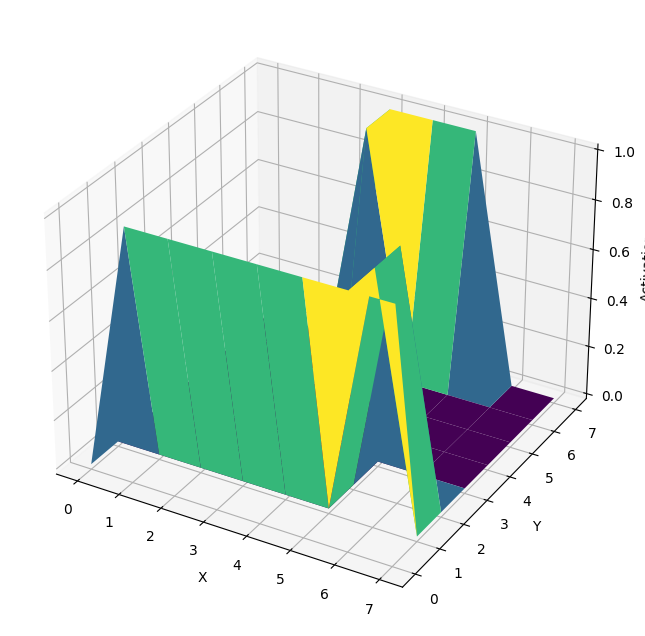

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming activation["Enc_syn1"] is of shape (250, 64, 8, 8)
data = activation["Enc_syn1"][:, 0, :, :].cpu().numpy()  # Transfer to CPU and convert to NumPy

# Create meshgrid for x and y dimensions
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Create a figure and a 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(x, y, data, cmap='viridis')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Activation')

# Show the 3D plot
plt.show()


## to access the saved files

In [ ]:
# Access activations for a specific epoch and layer
epoch_number = 4  # Replace with the epoch number you're interested in
layer_name = "Enc_syn1"  # Replace with the layer name you're interested in

# Access the activations for the specified epoch and layer
activations = epoch_activations[epoch_number][layer_name]

# Now, you can use the 'activations' variable for analysi

In [66]:
# checkpoint_path = "Saved_Trained_Checkpoints/"
# Output_Spikes = "Output_Spikes/"
# Enc_syn_Spikes = "Enc_syn_Spikes/"

# # Run training and testing
# for e in range(epochs):
#     train_loss = train(net, train_loader, optimizer, e)
#     train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

#     test_loss = test(net, test_loader, optimizer, e)
#     test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

#     # Save the model every 10 epochs
#     if (e + 1) % 10 == 0:
#         model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
#         torch.save(net.state_dict(), model_path)


#     # Add hooks for specific layers
#     hook_layers = [net.encoder[5], net.encoder[8]]  # You can choose the layers you want to capture activations from
#     hook_names = ["Enc_syn1", "Enc_syn2"]  # Names for the captured activations
#     hooks = []
#     for i, layer in enumerate(hook_layers):
#       hook_fn = get_activation(hook_names[i])
#       hooks.append(layer.register_forward_hook(hook_fn))


activation["Enc_syn1"]

print(activation["Enc_Lk1"].size())
print(activation["Enc_syn1"].size())
print(activation["Enc_syn2"].size())


torch.Size([250, 32, 16, 16])
torch.Size([250, 64, 8, 8])
torch.Size([250, 128, 4, 4])


In [ ]:
[[=]]
# # Set the path for saving checkpoints
# checkpoint_path = "Saved_Trained_Checkpoints/"

#    #Run training and testing
# for e in range(epochs):
#   train_loss = train(net, train_loader, optimizer, e)
#   train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))


#   test_loss = test(net,test_loader, optimizer, e)
#   test_avg_loss_rec.append(sum(test_loss_rec)/(len(test_loader)))

# # /////////////////////////////////////////////////////////////////////
#       # Save the model every 10 epochs
#   if (e + 1) % 10 == 0:
#     model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
#     torch.save(net.state_dict(), model_path)

# # After training
# # Access the out_en tensor
# out_en = net.out_en
# out_en_numpy = out_en.cpu().detach().numpy()
# np.save("out_en.npy", out_en_numpy)


In [ ]:
# spike_data = np.load("out_en.npy")

# # cmap = plt.get_cmap("binary")

# plt.imshow(spike_data, aspect="auto")
# # plt.xlabel("Time Steps")
# # plt.ylabel("Neurons")
# plt.title("Spike Activity in out_en")
# # plt.colorbar(label="Spikes")

# filename = f"(out_en)_spike_activity_epoch_{epochs}_b_syn_{beta_syn}.pdf"
# plt.savefig(filename, format="pdf")

# plt.show()

In [ ]:
# spike_data = np.load("out_en.npy")

# cmap = plt.get_cmap("binary")
# plt.imshow(spike_data, cmap=cmap, aspect="auto")
# # plt.xlabel("Time Steps")
# # plt.ylabel("Neurons")
# plt.title("Spike Activity in out_en")
# # plt.colorbar(label="Spikes")

# filename = f"(out_en)_spike_activity_epoch_{epochs}_b_syn_{beta_syn}_binary.pdf"
# plt.savefig(filename, format="pdf")
# plt.show()

## Loading the npy files

In [ ]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")
ax2_epoch = 50
spike_data_bench = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

ax1_epoch = 1
spike_data1_0001 = np.load(f"out_en_epoch_{ax1_epoch}.npy")
ax2_epoch = 50
spike_data_over = np.load(f"out_en_epoch_{ax2_epoch}.npy")



### Anaylizing the spike rates

In [ ]:
from scipy.stats import ttest_rel
spike_rate1=spike_data_bench
spike_rate2=spike_data_over


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Create histograms
ax1.hist(spike_rate1, bins=20, label='Epoch 50', alpha=0.75)
ax1.set_xlabel('Spike Rate')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Spike Rates (benchmark)')
# ax1.legend("benchmark")
ax2.hist(spike_rate2, bins=20, label='Epoch 50_0001', alpha=0.75)
ax2.set_xlabel('Spike Rate')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Spike Rates (over-firing)')
# ax2.legend("over-firing")

plt.show()



### Cross-Correlation over-firing and benchmark

In [ ]:
# ax1_epoch = 1
# spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")
# ax2_epoch = 50
# spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

spike_rate1=spike_data_bench
spike_rate2=spike_data_over


# Calculate cross-correlation between corresponding neurons in two epochs
cross_correlations = []
for i in range(spike_rate1.shape[1]):  # Assuming spike_data1 and spike_data2 have the same number of neurons
    cross_corr = correlate(spike_rate1[:, i], spike_rate2[:, i], mode='same')
    cross_correlations.append(cross_corr)

# Plot cross-correlations for a few neurons (e.g., the first 5)
for i in range(5):
    plt.plot(cross_correlations[i], label=f'Timestep {i + 1}')

plt.xlabel('Latent dim')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.title('Cross-Correlation Between Timesteps (benchmark) vs (overfiring)')
plt.show()


In [ ]:



# Calculate cross-correlation between corresponding neurons in two epochs
cross_correlations = []
for i in range(spike_rate1.shape[1]):  # Assuming spike_rate1 and spike_rate2 have the same number of neurons
    cross_corr = correlate(spike_rate1[:, i], spike_rate2[:, i], mode='same')

    # Normalize the cross-correlation
    cross_corr /= np.sqrt(np.sum(spike_rate1[:, i] ** 2) * np.sum(spike_rate2[:, i] ** 2))

    cross_correlations.append(cross_corr)

# # Plot normalized cross-correlations for a few timestep (e.g., the first 5)
for i in range(5):
    plt.plot(cross_correlations[i], label=f'Timestep {i + 1}')


# plt.plot(cross_correlations[4], label=f'Timestep {4 + 1}')

plt.xlabel('Latent dim')
plt.ylabel('Normalized Cross-Correlation')
plt.legend()
plt.title('Normalized Cross-Correlation Between Timesteps (benchmark) vs (overfiring)')
plt.show()


In [ ]:

# Assuming spike_data_bench and spike_data_over are loaded as numpy arrays with shape (32, 5)

# Calculate the cross-correlation
cross_corr = correlate(spike_data_bench, spike_data_over, mode='same')

# Calculate the denominators for each row separately
denominator = np.sqrt(np.sum(spike_data_bench ** 2, axis=1, keepdims=True) * np.sum(spike_data_over ** 2, axis=1, keepdims=True))

# Avoid division by zero by setting denominator to 1 where it's zero
denominator[denominator == 0] = 1

# Normalize the cross-correlation to [-1, 1]
cross_corr /= denominator

# Calculate time lags for plotting
time_lags = np.arange(-2, 3)  # Assuming 5 time steps in your data

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
for i in range(len(cross_corr)):
    plt.plot(time_lags, cross_corr[i], label=f'Latent Dim {i + 1}')

plt.xlabel('Time Lag')
plt.ylabel('Normalized Cross-Correlation')
plt.title('Cross-Correlation Between spike_data_bench and spike_data_over')
# plt.legend()
plt.grid(True)
plt.show()


# - The normalized cross-correlation ranges from -1 to 1.
# - A value of 1 indicates perfect positive correlation (identical patterns).
# - A value of -1 indicates perfect negative correlation (completely opposite patterns).
# - A value around 0 indicates no significant correlation (random or dissimilar patterns).

# You can print or analyze the 'cross_corr' array to see how correlated the spike patterns are for each latent dimension.


In [ ]:
# ax1_epoch = 1
# spike_data1_0001 = np.load(f"out_en_epoch_{ax1_epoch}.npy")
# ax2_epoch = 50
# spike_data2_0001 = np.load(f"out_en_epoch_{ax2_epoch}.npy")

# cross_correlations = []
# for i in range(spike_data1_0001.shape[1]):
#     cross_corr = correlate(spike_data1_0001[:, i], spike_data2_0001[:, i], mode='same')
#     cross_correlations.append(cross_corr)

# for i in range(5):
#     plt.plot(cross_correlations[i], label=f'Timestep {i + 1}')

# plt.xlabel('Latent dim')
# plt.ylabel('Cross-Correlation')
# plt.legend()
# plt.title('Cross-Correlation Between Timesteps (overfiring)')
# plt.show()


### Information Theory

In [ ]:
# Determine how much information is gained or lost when transitioning from spike_data1 to spike_data2.  You should analyze how spike patterns change from from spike_data1 to spike_data2 and calculate the information gain.
# please provide me the code based on each instruction below, wisely:
# 1. Data Normalization:
# Ensure that both spike_data1 and spike_data2 have the same scale or normalization. You may need to rescale or normalize the data so that they are directly comparable.
# 2. Data Discretization:
# Convert the spike data into discrete probability distributions. You can do this by discretizing the data into time bins and assigning probabilities to each bin based on spike counts.
# 3. Calculate Probability Distributions:
# Calculate probability distributions for both spike_data1 and spike_data2. These distributions represent the likelihood of observing spikes in each time bin.
# 4. Compute KL Divergence:
# Use the KL divergence formula to calculate the divergence between the two distributions.
# 5. Summation:
# Sum up the KL divergence values across all time steps and latent dimensions to obtain a single value representing the total information gain or loss when transitioning from spike_data1 to spike_data2.

spike_rate1=spike_data_bench
spike_rate2=spike_data_over

# # Step 1: Data Normalization
# spike_data1_normalized = spike_rate1 / np.max(spike_rate1)
# spike_data2_normalized = spike_rate2 / np.max(spike_rate2)

# Step 2: Data Discretization
num_bins = 10
spike_data1_discretized = np.histogramdd(np.where(spike_rate1 > 0), bins=num_bins)[0]
spike_data2_discretized = np.histogramdd(np.where(spike_rate2 > 0), bins=num_bins)[0]

# Step 3: Calculate Probability Distributions
epsilon = 1e-10  # Small constant to avoid division by zero
spike_data1_prob = (spike_data1_discretized + epsilon) / np.sum(spike_data1_discretized + epsilon)
spike_data2_prob = (spike_data2_discretized + epsilon) / np.sum(spike_data2_discretized + epsilon)

# Step 4: Compute KL Divergence
kl_divergence = kl_div(spike_data2_prob.flatten(), spike_data1_prob.flatten())
print("kl_divergence:", kl_divergence.shape)

# Step 5: Summation
total_information_gain = np.sum(kl_divergence)

print("Total Information Gain:", total_information_gain)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plot probability densities
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(spike_data1_prob, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Probability Density')
plt.xlabel("Latent Dimension")
plt.ylabel("Time Step")
plt.title("Probability Density - benchmark")

plt.subplot(1, 2, 2)
plt.imshow(spike_data2_prob, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Probability Density')
plt.xlabel("Latent Dimension")
plt.ylabel("Time Step")
plt.title("Probability Density - overfiring")

plt.tight_layout()
plt.show()


In [ ]:
# Define the number of bins for the histograms
num_bins = 20

# Create a figure with 5 subplots (one for each time step)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Iterate through time steps
for i in range(5):
    # Create a histogram for spike_data_bench at the current time step
    axes[i].hist(spike_data_bench[:, i], bins=num_bins, density=True, alpha=0.5, label='Benchmark')

    # Create a histogram for spike_data2 at the current time step
    axes[i].hist(spike_data_over[:, i], bins=num_bins, density=True, alpha=0.5, label='Over-firing')

    # Set labels and title for the subplot
    axes[i].set_xlabel("Latent Dimension")
    axes[i].set_ylabel("Probability Density")
    axes[i].set_title(f"Time Step {i}")
    axes[i].legend()

# Add a title for the entire figure
plt.suptitle("Probability Density of Spike Patterns for Different Time Steps")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the position of the main title
plt.show()








# spike_rate1=spike_data_bench
# spike_rate2=spike_data_over

# # Define the number of bins for the histograms
# num_bins = 10

# # Create histograms for spike_data1
# plt.figure(figsize=(12, 8))
# for i in range(5):  # 5 time steps
#     plt.subplot(2, 5, i + 1)
#     plt.hist(spike_rate1[:, i], bins=num_bins, density=True, alpha=0.5)
#     plt.title(f"Benchmark, Time Step {i}")
#     plt.xlabel("Spikes (0 or 1)")
#     plt.ylabel("Probability Density")

# # Create histograms for spike_data2
# for i in range(5):  # 5 time steps
#     plt.subplot(2, 5, i + 6)
#     plt.hist(spike_rate2[:, i], bins=num_bins, density=True, alpha=0.5)
#     plt.title(f"Over-firing, Time Step {i}")
#     plt.xlabel("Spikes (0 or 1)")
#     plt.ylabel("Probability Density")

# plt.tight_layout()
# plt.show()


In [ ]:
# Initialize an array to store KL Divergence values for each time step
kl_divergence_per_step = []

# Iterate through time steps
for i in range(5):
    # Calculate probability distributions for the two datasets at the current time step
    prob_dist_bench, _ = np.histogram(spike_data_bench[:, i], bins=num_bins, density=True)
    prob_dist_over, _ = np.histogram(spike_data_over[:, i], bins=num_bins, density=True)

    # Ensure that the two distributions have the same length
    min_len = min(len(prob_dist_bench), len(prob_dist_over))
    prob_dist_bench = prob_dist_bench[:min_len]
    prob_dist_over = prob_dist_over[:min_len]

    # Calculate KL Divergence for the current time step
    kl_divergence = entropy(prob_dist_bench, prob_dist_over)

    kl_divergence_per_step.append(kl_divergence)

# Plot the KL Divergence values for each time step
plt.figure(figsize=(10, 5))
plt.plot(range(5), kl_divergence_per_step, marker='o')
plt.xlabel("Time Step")
plt.ylabel("KL Divergence")
plt.title("KL Divergence for Each Time Step")
plt.grid(True)
plt.show()

# Print KL Divergence values
for i, kl_divergence in enumerate(kl_divergence_per_step):
    print(f"Time Step {i}: KL Divergence = {kl_divergence}")

# ------------------------------ information gain or loss
# Flatten the kl_divergence_per_step list to include all time steps
kl_divergence_flat = np.array(kl_divergence_per_step)

# Sum up the KL divergence values across all time steps and latent dimensions
total_kl_divergence = np.sum(kl_divergence_flat)

# Print the total KL Divergence
print(f"Total KL Divergence: {total_kl_divergence}")


In [ ]:

# # 2. Probability Distributions
# plt.figure(figsize=(12, 6))
# for i in range(4):
#     plt.subplot(2, 2, i + 1)
#     sns.histplot(spike_data1[i], bins=20, label="Benchmark", color='blue', kde=True)
#     sns.histplot(spike_data2[i], bins=20, label="Over-firing", color='red', kde=True)
#     plt.xlabel(f"Latent Dimension {i}")
#     plt.ylabel("Probability Density")
#     plt.legend()
# plt.tight_layout()
# plt.show()

# # 3. Heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(kl_divergence, cmap="YlGnBu", annot=True, fmt=".3f")
# plt.xlabel("Latent Dimension")
# plt.ylabel("Time Step")
# plt.title("KL Divergence Heatmap")
# plt.show()

# # 4. Time Series Plot
# time_steps = np.arange(4)
# plt.figure(figsize=(8, 6))
# plt.plot(time_steps, kl_divergence.mean(axis=1), marker='o')
# plt.xlabel("Time Step")
# plt.ylabel("Mean KL Divergence")
# plt.title("KL Divergence Over Time")
# plt.xticks(time_steps)
# plt.show()

# # 5. Latent Dimension Comparison
# latent_dim_to_compare = 0  # Choose a specific latent dimension to compare
# plt.figure(figsize=(8, 6))
# sns.histplot(spike_data1[:, latent_dim_to_compare], label="Benchmark", color='blue', kde=True)
# sns.histplot(spike_data2[:, latent_dim_to_compare], label="Over-firing", color='red', kde=True)
# plt.xlabel(f"Latent Dimension {latent_dim_to_compare}")
# plt.ylabel("Probability Density")
# plt.legend()
# plt.title(f"Latent Dimension {latent_dim_to_compare} Comparison")
# plt.show()

# # 7. Summary Statistics
# mean_kl_divergence = kl_divergence.mean()
# median_kl_divergence = np.median(kl_divergence)
# std_kl_divergence = kl_divergence.std()
# print(f"Mean KL Divergence: {mean_kl_divergence:.3f}")
# print(f"Median KL Divergence: {median_kl_divergence:.3f}")
# print(f"Standard Deviation of KL Divergence: {std_kl_divergence:.3f}")

# # 8. Anomaly Detection Plot (set a threshold)
# threshold = 0.1  # Adjust the threshold as needed
# anomalies = np.where(kl_divergence > threshold, 1, 0)
# plt.figure(figsize=(10, 6))
# sns.heatmap(anomalies, cmap="Reds", annot=True, fmt=".0f")
# plt.xlabel("Latent Dimension")
# plt.ylabel("Time Step")
# plt.title(f"Anomalies (Threshold = {threshold})")
# plt.show()




# Encoder plotting each epochs output of out_en:

## Heatmap or Cmap plot of the Endoer spikes

In [ ]:
# ax1_epoch = 1
# spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")
# ax2_epoch = 50
# spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

ax1_epoch = 50
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")

ax2_epoch = 50
spike_data2 = np.load(f"out_en_epoch_{ax2_epoch}.npy")


font_size = 15
font = {'weight': 'bold', 'size': 15}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
cmap = plt.get_cmap("binary")
ax1.imshow(spike_data1, cmap=cmap, aspect="auto")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax1.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out_en" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
cmap = plt.get_cmap("binary")
ax2.imshow(spike_data2, cmap=cmap, aspect="auto")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax2.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out_en" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_cmap.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_cmap.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()



## Raster plot of the Encoder spikes

In [ ]:
ax1_epoch = 50
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")

ax2_epoch = 50
spike_data2 = np.load(f"out_en_epoch_{ax2_epoch}.npy")

font_size = 15
font = {'weight': 'bold', 'size': 15}

# plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
# Find the coordinates of spike events
coords = np.argwhere(spike_data1)
ax1.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax1.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out_en" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
coords = np.argwhere(spike_data2)
ax2.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax2.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out_en" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_raster.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_raster.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()


In [ ]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")

ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

font_size = 15
font = {'weight': 'bold', 'size': 15}

# plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
# Find the coordinates of spike events
coords = np.argwhere(spike_data1)
ax1.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax1.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out_en" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
coords = np.argwhere(spike_data2)
ax2.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax2.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out_en" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_raster.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_raster.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()


## 3D plot of the Encoder sppikes

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")

ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))

# Create the first subplot for spike_data1
ax1 = fig.add_subplot(121, projection='3d')
x1, y1 = np.meshgrid(np.arange(spike_data1.shape[1]), np.arange(spike_data1.shape[0]))
z1 = spike_data1.flatten()
ax1.scatter(x1.flatten(), y1.flatten(), z1, s=60, marker="|", color="black")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Latent dim")
ax1.set_zlabel("Spike Intensity", labelpad=2)
ax1.set_title(f"Spike Activity in out_en (Epoch {ax1_epoch})")

# Create the second subplot for spike_data2
ax2 = fig.add_subplot(122, projection='3d')
x2, y2 = np.meshgrid(np.arange(spike_data2.shape[1]), np.arange(spike_data2.shape[0]))
z2 = spike_data2.flatten()
ax2.scatter(x2.flatten(), y2.flatten(), z2, s=60, marker="|", color="black")
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Latent dim")
ax2.set_zlabel("Spike Intensity", labelpad=0.1)
ax2.set_title(f"Spike Activity in out_en (Epoch {ax2_epoch})")

# Adjust spacing between subplots
plt.tight_layout()
# Manually adjust the position of the second subplot
# pos = ax2.get_position()
# pos.x0 += 0.1  # Adjust the left position
# pos.x1 += 0.1  # Adjust the right position
# ax2.set_position(pos)

# Save and display the plot
filename = f"Enc_b_syn_{beta_syn}_spike_epochs_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_3D.pdf"
plt.savefig(filename, format="pdf")
plt.show()


# Decoder plotting each epochs output of out:

## cmap plotting Decoder of (for one digit at the last time t)

In [ ]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_epoch_{ax1_epoch}.npy")
spike_data1 = spike_data1[0,0,:, :]
ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_epoch_{ax2_epoch}.npy")
spike_data2 = spike_data2[0,0,:, :]

font_size = 15
font = {'weight': 'bold', 'size': 15}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
cmap = plt.get_cmap("binary")
ax1.imshow(spike_data1, cmap=cmap, aspect="auto")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("width", fontweight="bold", fontdict=font)
ax1.set_ylabel("length", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
cmap = plt.get_cmap("binary")
ax2.imshow(spike_data2, cmap=cmap, aspect="auto")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("width", fontweight="bold", fontdict=font)
ax2.set_ylabel("length", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Dec_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_cmap.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_cmap.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()



## Raster plot Decoder of (for one digit at the last time t)

In [ ]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_epoch_{ax1_epoch}.npy")
spike_data1 = spike_data1[0,0,:, :]
ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_epoch_{ax2_epoch}.npy")
spike_data2 = spike_data2[0,0,:, :]

font_size = 15
font = {'weight': 'bold', 'size': 15}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
coords = np.argwhere(spike_data1)
ax1.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("width", fontweight="bold", fontdict=font)
ax1.set_ylabel("length", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
coords = np.argwhere(spike_data2)
ax2.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("width", fontweight="bold", fontdict=font)
ax2.set_ylabel("length", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Dec_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_raster.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_cmap.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()



## 3D plotting Decoder of (for one digit at the last time t)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_epoch_{ax1_epoch}.npy")
spike_data1 = spike_data1[0,0,:, :]

ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_epoch_{ax2_epoch}.npy")
spike_data2 = spike_data2[0,0,:, :]

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))

# Create the first subplot for spike_data1
ax1 = fig.add_subplot(121, projection='3d')
x1, y1 = np.meshgrid(np.arange(spike_data1.shape[1]), np.arange(spike_data1.shape[0]))
z1 = spike_data1.flatten()
ax1.scatter(x1.flatten(), y1.flatten(), z1, s=60, marker="|", color="black")
ax1.set_xlabel("width")#, fontweight="bold", fontdict=font)
ax1.set_ylabel("length")#, fontweight="bold", fontdict=font)
ax1.set_zlabel("Spike Intensity", labelpad=2)#, fontweight="bold", fontdict=font)
ax1.set_title(f"Spike Activity in out_en (Epoch {ax1_epoch})")

# Create the second subplot for spike_data2
ax2 = fig.add_subplot(122, projection='3d')
x2, y2 = np.meshgrid(np.arange(spike_data2.shape[1]), np.arange(spike_data2.shape[0]))
z2 = spike_data2.flatten()
ax2.scatter(x2.flatten(), y2.flatten(), z2, s=60, marker="|", color="black")
ax2.set_xlabel("width")#, fontweight="bold", fontdict=font)
ax2.set_ylabel("length")#, fontweight="bold", fontdict=font)
ax2.set_zlabel("Spike Intensity", labelpad=0.1)#, fontweight="bold", fontdict=font)
ax2.set_title(f"Spike Activity in out_en (Epoch {ax2_epoch})")

# Adjust spacing between subplots
plt.tight_layout()
# Manually adjust the position of the second subplot
# pos = ax2.get_position()
# pos.x0 += 0.1  # Adjust the left position
# pos.x1 += 0.1  # Adjust the right position
# ax2.set_position(pos)

# Save and display the plot
filename = f"Dec_b_syn_{beta_syn}_spike_epochs_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_3D.pdf"
plt.savefig(filename, format="pdf")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the 'out' tensor for a specific epoch
epoch_number = 50  # Change this to the epoch you want to visualize
out_filename = f"out_epoch_{epoch_number}.npy"
out = np.load(out_filename)
print("out:",out.shape)  # Using .shape attribute

# Reshape the data if needed
# For example, if 'out' is a 4D tensor and you want to visualize a specific slice
# along one of the dimensions, you can reshape it to a 2D matrix for plotting.

# Example reshape (adjust dimensions as needed)
out = out.reshape(-1, out.shape[-1])  # Flatten all dimensions except the last one
print("out.reshape(-1, out.shape[-1]): ",out.shape)  # Using .shape attribute
# or
# print(out.size())  # Using .size() method
# Create a plot
plt.figure(figsize=(10, 6))
plt.imshow(out, cmap='viridis', aspect='auto', interpolation='nearest')
plt.xlabel("Dimension")
plt.ylabel("Samples")
plt.title("Decoder Representations (for one digit at the last time t)" + " [epoch: " + str(epoch_number) + "]")

plt.colorbar(label='Spike Count')

filename = f"Dec_b_syn_{beta_syn}_spike_epochs_{epoch_number}_of_{epochs}_(8000x32).pdf"
plt.savefig(filename, format="pdf")

plt.show()
